<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Target" data-toc-modified-id="Target-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Target</a></span></li></ul></div>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [4]:
# # Load data
df_train = pd.read_csv('../data/training_set_VU_DM.csv')

df_test = pd.read_csv('../data/test_set_VU_DM.csv')

df_example_output = pd.read_csv('../data/submission_sample.csv')

<h3>Target</h3>

We need to predict search order. 

test set misses: position, click_bool, booking_bool, gross_booking_usd

each line in the data describes one hotel in one search

In [40]:
searches = df_train['srch_id'].unique()
properties = df_train['prop_id'].unique()
print(len(searches))
print(len(properties))

199795
129113


In [8]:
df_example_output.head(100)

,srch_id,prop_id
0,1,3180
1,1,5543
2,1,14142
3,1,22393
4,1,24194
...,...,...
95,10,11203
96,10,23777
97,10,31281
98,10,37420


In [26]:
print(df_train.shape)
print(df_test.shape)
df_train.describe()

(4958347, 54)
(4959183, 50)


,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
count,4.958347e+06,4.958347e+06,4.958347e+06,251866.000000,252988.000000,4.958347e+06,4.958347e+06,4.958347e+06,4.950983e+06,4.958347e+06,...,96174.000000,315348.000000,356422.000000,138515.000000,1.916654e+06,1.987503e+06,614730.000000,4.958347e+06,138390.000000,4.958347e+06
mean,1.663666e+05,9.953133e+00,1.753405e+02,3.374334,176.022659,1.739739e+02,7.007918e+04,3.180525e+00,3.777777e+00,6.346994e-01,...,17.250473,0.145969,0.083202,19.433267,-6.089936e-02,9.962752e-03,22.430384,4.474858e-02,386.283316,2.791051e-02
std,9.611223e+04,7.646890e+00,6.591625e+01,0.692519,107.254493,6.834525e+01,4.060992e+04,1.051024e+00,1.050329e+00,4.815144e-01,...,31.160313,0.578202,0.316722,54.370221,4.691723e-01,2.029142e-01,895.965854,2.067514e-01,821.190577,1.647165e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.410000,0.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000,-1.000000,-1.000000,2.000000,-1.000000e+00,-1.000000e+00,2.000000,0.000000e+00,0.000000,0.000000e+00
25%,8.293600e+04,5.000000e+00,1.000000e+02,2.920000,109.810000,1.000000e+02,3.501000e+04,3.000000e+00,3.500000e+00,0.000000e+00,...,6.000000,0.000000,0.000000,7.000000,0.000000e+00,0.000000e+00,7.000000,0.000000e+00,124.000000,0.000000e+00
50%,1.665070e+05,5.000000e+00,2.190000e+02,3.450000,152.240000,2.190000e+02,6.963800e+04,3.000000e+00,4.000000e+00,1.000000e+00,...,11.000000,0.000000,0.000000,12.000000,0.000000e+00,0.000000e+00,11.000000,0.000000e+00,218.400000,0.000000e+00
75%,2.497240e+05,1.400000e+01,2.190000e+02,3.930000,213.490000,2.190000e+02,1.051680e+05,4.000000e+00,4.500000e+00,1.000000e+00,...,18.000000,1.000000,0.000000,20.000000,0.000000e+00,0.000000e+00,17.000000,0.000000e+00,429.790000,0.000000e+00
max,3.327850e+05,3.400000e+01,2.310000e+02,5.000000,1958.700000,2.300000e+02,1.408210e+05,5.000000e+00,5.000000e+00,1.000000e+00,...,1620.000000,1.000000,1.000000,9900.000000,1.000000e+00,1.000000e+00,149400.000000,1.000000e+00,159292.380000,1.000000e+00


In [23]:
col_with_nan = df_train.columns[df_train.isna().any()].tolist()
df_nans = df_train[col_with_nan].isnull().sum().sort_values(ascending=False)
df_nans

comp1_rate_percent_diff      4863908
comp6_rate_percent_diff      4862173
comp1_rate                   4838417
comp1_inv                    4828788
comp4_rate_percent_diff      4827261
gross_bookings_usd           4819957
comp7_rate_percent_diff      4819832
comp6_rate                   4718190
visitor_hist_starrating      4706481
visitor_hist_adr_usd         4705359
comp6_inv                    4697371
comp4_rate                   4650969
comp7_rate                   4642999
srch_query_affinity_score    4640941
comp4_inv                    4614684
comp7_inv                    4601925
comp3_rate_percent_diff      4485550
comp2_rate_percent_diff      4402109
comp8_rate_percent_diff      4343617
comp5_rate_percent_diff      4117248
comp3_rate                   3424059
comp3_inv                    3307357
comp8_rate                   3041693
comp8_inv                    2970844
comp2_rate                   2933675
comp2_inv                    2828078
comp5_rate                   2735974
c

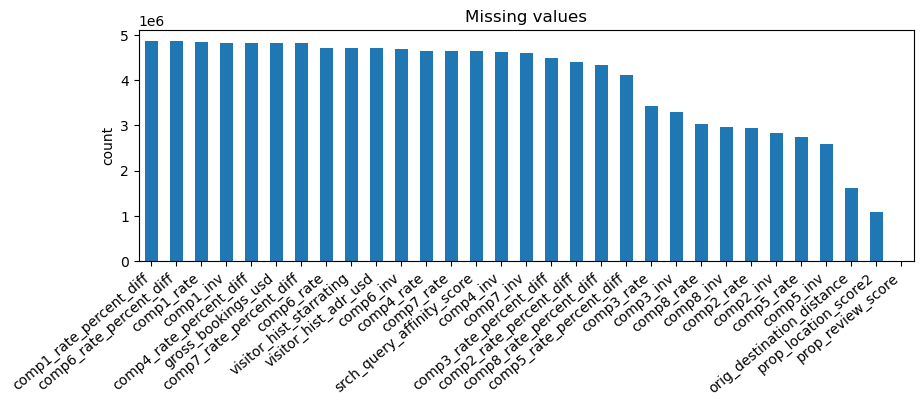

In [47]:
ax = df_nans.plot(kind='bar', title='Missing values', rot=45, figsize=(10,3))
ax.set_ylabel("count")
plt.setp(ax.get_xticklabels(), rotation=40, horizontalalignment='right')
plt.savefig('nans.png', bbox_inches='tight')

In [ ]:
# iterate over variables
for col in df_train.columns:
    # Describe value column for variable
    print(f"Variable {col}:")
    print(df_train[col].describe())

In [5]:
df_new = df_train.fillna(-1)
corr = df_new.corr()

/var/folders/mb/lst460j57bjgz_ly8cz3gq400000gn/T/ipykernel_12300/250151468.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_new.corr()


In [7]:
df_new

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,-1.0,-1.0,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,-1.0,-1.00,1,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0,-1.00,0
1,1,2013-04-04 08:32:15,12,187,-1.0,-1.0,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,-1.0,-1.00,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0,-1.00,0
2,1,2013-04-04 08:32:15,12,187,-1.0,-1.0,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,-1.0,-1.00,1,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0,-1.00,0
3,1,2013-04-04 08:32:15,12,187,-1.0,-1.0,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,-1.0,-1.00,1,-1.0,-1.0,-1.0,-1.0,0.0,5.0,-1.0,0.0,5.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,5.0,0,-1.00,0
4,1,2013-04-04 08:32:15,12,187,-1.0,-1.0,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,-1.0,-1.00,1,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0,-1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958342,332785,2013-06-30 19:55:18,5,219,-1.0,-1.0,219,77700,3,4.0,1,1.61,0.0471,0.00,2,118.00,0,16974,1,21,3,0,1,0,-1.0,550.92,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1.00,0
4958343,332785,2013-06-30 19:55:18,5,219,-1.0,-1.0,219,88083,3,4.0,1,1.95,0.1520,0.00,3,89.00,0,16974,1,21,3,0,1,0,-1.0,553.14,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1.00,0
4958344,332785,2013-06-30 19:55:18,5,219,-1.0,-1.0,219,94508,3,3.5,1,1.10,0.0164,0.00,4,99.00,0,16974,1,21,3,0,1,0,-1.0,544.43,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,-1.00,0
4958345,332785,2013-06-30 19:55:18,5,219,-1.0,-1.0,219,128360,3,5.0,1,1.95,0.0662,0.00,1,139.00,0,16974,1,21,3,0,1,0,-1.0,550.38,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,157.84,1


In [6]:
corr.sort_values('booking_bool')

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
position,-0.001505,-0.031194,0.018716,-0.006409,-0.006991,0.029850,-0.000320,-0.107717,-0.053693,0.023419,0.003340,-0.169544,-0.008703,1.000000,-1.880077e-03,-0.103621,-0.003988,-0.006361,-0.008636,-0.009098,-0.022136,-0.024657,-0.003560,-0.015996,0.003894,-0.015492,0.001168,0.004439,0.001260,0.020662,0.027097,-1.472837e-03,0.015528,0.025169,0.000772,-0.015974,-0.013274,0.000567,0.001394,0.014856,0.000089,-0.015499,-0.015335,-0.004950,-0.016895,-0.016945,-0.004435,0.024903,0.036668,0.000412,-0.164992,-0.061675,-0.147918
random_bool,-0.000697,0.026814,-0.037232,-0.069986,-0.059053,-0.030175,0.002507,-0.004763,-0.051453,-0.048390,0.005867,-0.015360,0.007561,-0.015492,-1.461007e-03,-0.022626,-0.003828,0.176213,0.148153,0.050721,0.015594,-0.003915,-0.028863,0.074229,0.011559,1.000000,-0.004677,0.000707,0.000249,-0.057157,-0.061346,-1.477378e-03,-0.057555,-0.059135,0.000346,-0.004959,-0.001395,-0.000231,-0.053833,-0.057244,0.000168,-0.019289,-0.019090,-0.005278,-0.022442,-0.021195,-0.004585,-0.070015,-0.078154,-0.000560,0.005819,-0.037483,-0.088891
srch_length_of_stay,-0.001256,0.106386,-0.097225,-0.011258,-0.002038,-0.084679,0.001863,0.091217,-0.022007,-0.107402,0.117521,0.030674,0.033426,-0.006361,1.565352e-03,0.115967,-0.003812,1.000000,0.262616,0.011260,0.038336,0.002111,-0.293019,0.044439,0.137279,0.176213,0.027177,0.028748,0.002442,-0.086291,-0.102273,-2.294127e-03,-0.089518,-0.099556,-0.000847,0.027453,0.029735,0.000175,-0.058727,-0.072201,-0.000089,-0.003059,-0.002615,0.000396,-0.004017,-0.006043,-0.001405,-0.133732,-0.160673,-0.001119,0.002647,0.045217,-0.024412
srch_booking_window,-0.002946,0.168395,-0.087573,-0.014610,-0.002148,-0.118640,0.000222,0.074016,0.004755,-0.097656,0.119707,0.049541,0.079877,-0.008636,1.516541e-03,0.027074,-0.003157,0.262616,1.000000,0.110007,0.052099,0.039504,-0.079922,0.024419,0.205608,0.148153,-0.023260,-0.026848,-0.003547,-0.269469,-0.308548,-1.048836e-02,-0.250295,-0.282336,-0.004444,-0.064814,-0.078916,-0.001177,-0.249279,-0.300248,-0.004625,-0.053944,-0.060987,-0.020909,-0.055712,-0.066018,-0.014846,-0.300108,-0.354894,-0.004986,0.001707,0.009566,-0.019582
srch_adults_count,0.004007,-0.022573,0.002687,-0.056060,-0.042493,0.028440,0.000213,0.006948,0.019160,0.006918,0.019014,0.024533,-0.010369,-0.009098,1.954506e-03,0.017321,-0.000952,0.011260,0.110007,1.000000,0.096640,0.471428,0.063918,-0.015116,-0.006160,0.050721,-0.006948,-0.010457,-0.005142,-0.008097,-0.008854,-7.898245e-04,-0.013094,-0.015331,-0.001448,-0.026163,-0.029784,-0.000722,-0.026085,-0.034137,-0.001518,-0.027221,-0.032744,-0.010442,-0.032440,-0.039531,-0.008961,-0.006694,-0.008134,-0.001154,0.004620,0.013202,-0.005376
srch_query_affinity_score,-0.000296,0.060602,-0.059113,0.038383,0.032489,-0.053984,0.001396,0.033405,-0.014706,-0.036393,0.038273,0.058717,0.003429,-0.015996,1.402709e-03,0.016399,-0.004957,0.044439,0.024419,-0.015116,0.018134,0.027281,-0.030965,1.000000,0.021786,0.074229,0.011649,0.013293,0.003996,-0.024951,-0.030884,-1.605613e-05,-0.024364,-0.026753,0.000453,0.020290,0.022707,0.001005,0.007609,0.008428,0.000581,0.019404,0.022091,0.006529,0.022815,0.02674

In [7]:
subset = df_train.head(500)
df_train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [53]:
searches_train = df_train['prop_id'].unique()
searches_test = df_test['prop_id'].unique()
print(len(searches_train))
print(len(searches_test))

129113
129438


In [52]:
missing = []
for prop in searches_train:
    if prop not in searches_test:
        missing.append(prop)
print(len(missing))

7448


In [54]:
missing = []
for prop in searches_test:
    if prop not in searches_train:
        missing.append(prop)
print(len(missing))

7773
